In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost
import matplotlib.pyplot as plt
import lightgbm
import catboost
import optuna
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=GradientBoostingClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [3]:
RANDOM_STATE = 42
results = pd.DataFrame(columns = ['model', 'task', 'accuracy'])

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [4]:
data = pd.read_csv('winequality-red.csv', sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1.Разделите выборку на обучающую и тестовую в отношении 70%/30%, предварительно выделив целевую переменную (колонка 'quality').

In [5]:
X, y = data.loc[:, data.columns != 'quality'], data.loc[:, data.columns == 'quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)
print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(480, 11) (1119, 11) (480, 1) (1119, 1)


2.Оцените качество на тестовой выборке по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [6]:
dt = DecisionTreeClassifier()
bc = BaggingClassifier(n_estimators=100)
rfc = RandomForestClassifier(n_estimators=100)

In [7]:
dt.fit(X_train, y_train.values.ravel())
bc.fit(X_train, y_train.values.ravel())
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [8]:
### Ваш код ###
acc_DT = accuracy_score(y_test, dt.predict(X_test))
acc_Bagging = accuracy_score(y_test, bc.predict(X_test))
acc_RF = accuracy_score(y_test, rfc.predict(X_test))
results.loc[0] = ['DecisionTreeClassifier', 'task2', acc_DT]
results.loc[1] = ['BaggingClassifier ', 'task2', acc_Bagging]
results.loc[2] = ['RandomForestClassifier', 'task2', acc_RF]

In [9]:
results

,model,task,accuracy
0,DecisionTreeClassifier,task2,0.566667
1,BaggingClassifier,task2,0.633333
2,RandomForestClassifier,task2,0.681250


Результаты 2-ух последних решений лучше, благодаря bootstrap.

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [10]:
trees = [10, 50, 100, 200]
trees.extend(list(range(400, 5200, 200)))
rfc_acc = []
rfc = RandomForestClassifier()

for i, n in tqdm(enumerate(trees)):
    rfc.n_estimators = n
    rfc.fit(X_train, y_train.values.ravel())
    rfc_acc.append(accuracy_score(y_test, rfc.predict(X_test)).mean())
print(rfc_acc)

0it [00:00, ?it/s]

[0.6354166666666666, 0.6645833333333333, 0.6708333333333333, 0.6666666666666666, 0.6645833333333333, 0.6625, 0.6708333333333333, 0.6770833333333334, 0.6708333333333333, 0.66875, 0.6729166666666667, 0.6729166666666667, 0.6729166666666667, 0.6708333333333333, 0.66875, 0.6645833333333333, 0.6708333333333333, 0.6666666666666666, 0.6708333333333333, 0.6708333333333333, 0.66875, 0.6729166666666667, 0.66875, 0.6770833333333334, 0.675, 0.66875, 0.6708333333333333, 0.675]


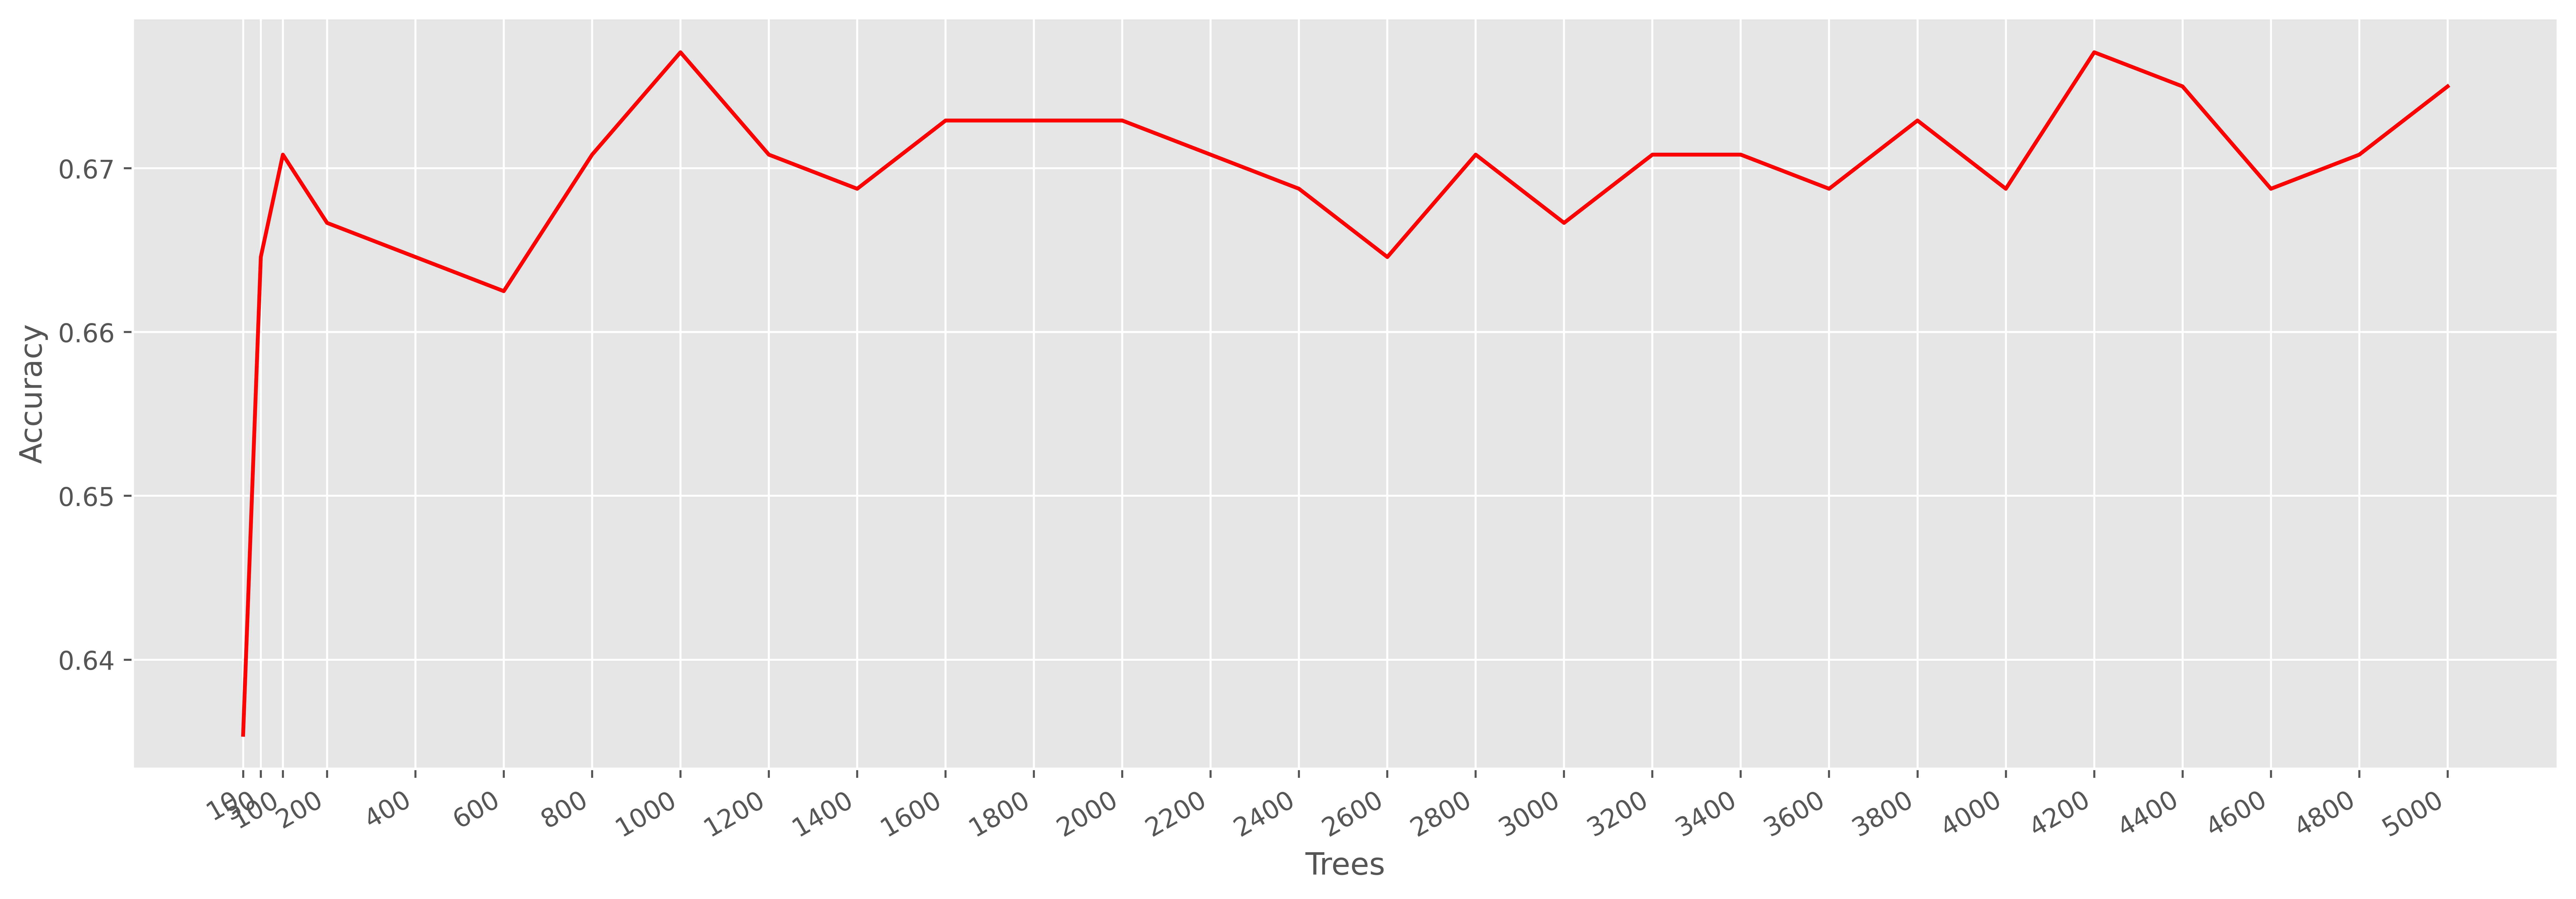

<Figure size 4200x10500 with 0 Axes>

In [11]:
plt.rcParams['figure.dpi'] = 700
plt.style.use('ggplot')
fig, ax = plt.subplots()
plt.figure(figsize=(6, 15))
fig.set_figwidth(17)
fig.set_figheight(6)
ax.plot(trees, rfc_acc, color='red')
ax.set_xticks(trees)
fig.autofmt_xdate()
ax.set_xlabel('Trees')
ax.set_ylabel('Accuracy');

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [12]:
xboost = xgboost.XGBClassifier()
gbc = GradientBoostingClassifier()
le = LabelEncoder()
yb = le.fit_transform(y.values.ravel())

In [13]:
acc_sklearn = cross_val_score(gbc, X, y.values.ravel(), scoring='accuracy').mean()
acc_xgboost = cross_val_score(xboost, X, yb, scoring='accuracy').mean()
results.loc[3] = ['GradientBoostingClassifier', 'task4', acc_sklearn]
results.loc[4] = ['XGBClassifier', 'task4', acc_xgboost]

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [14]:
trees = [1, 5, 10, 50]
trees.append(list(range(100, 1001, 100)))
pipe = Pipeline([('estimator', ClfSwitcher())])
parameters = [
    {
    'estimator__estimator': [GradientBoostingClassifier()],
    'estimator__estimator__learning_rate': list(np.round(np.arange(0.1, 1.1, 0.1), 1)),
    'estimator__estimator__n_estimators': trees,
    'estimator__estimator__max_depth': list(range(1, 7)),
    },
    {
    'estimator__estimator': [xgboost.XGBClassifier()],
    'estimator__estimator__eta': list(np.round(np.arange(0.1, 1.1, 0.1), 1)),
    'estimator__estimator__n_estimators': trees,
    'estimator__estimator__max_depth': list(range(1, 7)),
    },
    {
    'estimator__estimator': [lightgbm.LGBMClassifier()],
    'estimator__estimator__learning_rate': list(np.round(np.arange(0.1, 1.1, 0.1), 1)),
    'estimator__estimator__n_estimators': trees,
    'estimator__estimator__max_depth': list(range(1, 7)),
    },
    {
    'estimator__estimator': [catboost.CatBoostClassifier()],
    'estimator__estimator__learning_rate': list(np.round(np.arange(0.1, 1.1, 0.1), 1)),
    'estimator__estimator__n_estimators': trees,
    'estimator__estimator__max_depth': list(range(1, 7)),
    'estimator__estimator__silent': [True],
    },
]

In [15]:
gs_gbc = GridSearchCV(pipe, param_grid=parameters[0], cv=3, scoring='accuracy')
gs_gbc.fit(X, y.values.ravel())
gs_xboost = GridSearchCV(pipe, parameters[1], cv=3, scoring='accuracy')
gs_xboost.fit(X, yb)


best_params_sklearn = gs_gbc.best_params_
print('Параметры лучшей модели sklearn:\n', best_params_sklearn)
best_params_xgboost = gs_xboost.best_params_
print('Параметры лучшей модели xgboost:\n', best_params_xgboost)
acc_sklearn_cv = gs_gbc.best_score_
acc_xgboost_cv = gs_xboost.best_score_
results.loc[5] = ['GradientBoostingClassifier_CV', 'task5', acc_sklearn_cv]
results.loc[6] = ['XGBClassifier_CV', 'task5', acc_xgboost_cv]

Параметры лучшей модели sklearn:
 {'estimator__estimator': GradientBoostingClassifier(learning_rate=0.3, max_depth=2, n_estimators=10), 'estimator__estimator__learning_rate': 0.3, 'estimator__estimator__max_depth': 2, 'estimator__estimator__n_estimators': 10}
Параметры лучшей модели xgboost:
 {'estimator__estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=10, n_jobs=None,
  

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [16]:
lightgbm_model = lightgbm.LGBMClassifier()
catboost_model = catboost.CatBoostClassifier(silent=True)

In [17]:
acc_lightgbm = cross_val_score(lightgbm_model, X, y, scoring='accuracy').mean()
acc_catboost = cross_val_score(catboost_model, X, y, scoring='accuracy').mean()
results.loc[7] = ['LGBMClassifier', 'task6', acc_lightgbm]
results.loc[8] = ['CatBoostClassifier', 'task6', acc_catboost]

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями.
Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [18]:
gs_lightgbm = GridSearchCV(pipe, param_grid=parameters[2], cv=3, scoring='accuracy')
gs_lightgbm.fit(X, y.values.ravel())
gs_catboost = GridSearchCV(pipe, param_grid=parameters[3], cv=3, scoring='accuracy')
gs_catboost.fit(X, y.values.ravel())

best_params_lightgbm = gs_lightgbm.best_params_
print('Параметры лучшей модели lightgbm:\n', best_params_lightgbm)
best_params_catboost = gs_catboost.best_params_
print('Параметры лучшей модели catboost:\n', best_params_catboost)
acc_lightgbm_cv = gs_lightgbm.best_score_
acc_catboost_cv = gs_catboost.best_score_
results.loc[9] = ['LGBMClassifier_CV', 'task7', acc_lightgbm_cv]
results.loc[10] = ['CatBoostClassifier_CV', 'task7', acc_catboost_cv]

Параметры лучшей модели lightgbm:
 {'estimator__estimator': LGBMClassifier(max_depth=3, n_estimators=10), 'estimator__estimator__learning_rate': 0.1, 'estimator__estimator__max_depth': 3, 'estimator__estimator__n_estimators': 10}
Параметры лучшей модели catboost:
 {'estimator__estimator': <catboost.core.CatBoostClassifier object at 0x7f4b05104850>, 'estimator__estimator__learning_rate': 0.1, 'estimator__estimator__max_depth': 4, 'estimator__estimator__n_estimators': 50, 'estimator__estimator__silent': True}


8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [19]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [21]:
y_test_b = le.fit_transform(y_test.values.ravel())
y_train_b = le.fit_transform(y_train.values.ravel())


def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e0, step=1e-2)
    xg_trees = trial.suggest_int('xg_trees', 1, 1001, step=50)
    xg_max_depth = trial.suggest_int('xg_max_depth', 1, 20)
    regressor_obj = xgboost.XGBClassifier(n_estimators=xg_trees, learning_rate=learning_rate, max_depth=xg_max_depth)

    regressor_obj.fit(X_train, y_train_b)
    y_pred = regressor_obj.predict(X_test)

    acc = accuracy_score(y_test_b, y_pred)

    return acc  # An objective value linked with the Trial object.


study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

In [22]:
best_params_xgboost_optuna = study.best_params
print('Параметры лучшей модели xgboost:\n', best_params_xgboost_optuna)
acc_xgboost_optuna = study.best_trial.value
results.loc[11] = ['XGBClassifier_optuna', 'task8', acc_xgboost_optuna]

Параметры лучшей модели xgboost:
 {'learning_rate': 0.18000000000000002, 'xg_trees': 1, 'xg_max_depth': 13}


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [23]:
estimators = [
    ('g1', GradientBoostingClassifier()),
    ('g2', GradientBoostingClassifier()),
    ('g3', GradientBoostingClassifier()),
    ('g4', GradientBoostingClassifier()),
]
sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [24]:
y_pred = sc.fit(X_train, y_train.values.ravel()).predict(X_test)

In [25]:
acc_stacking_default = accuracy_score(y_test, y_pred)
results.loc[12] = ['Stacking default', 'task9', acc_stacking_default]

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [40]:
def objective(trial):

    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e0, step=1e-2)
    gbc_estimators = trial.suggest_int('gbc_estimators', 1, 50, step=1)
    gbc_max_depth = trial.suggest_int('gbc_max_depth', 1, 30, step=1)
    regressor_obj = GradientBoostingClassifier(n_estimators=gbc_estimators,\
                                               learning_rate=learning_rate,\
                                               max_depth=gbc_max_depth)

    return cross_val_score(regressor_obj, X, y.values.ravel()).mean()

study = optuna.create_study()
study.optimize(objective, n_trials=500)

In [42]:
study.best_params

{'learning_rate': 0.6, 'gbc_estimators': 1, 'gbc_max_depth': 27}

In [43]:
estimators = [
    ('g1', GradientBoostingClassifier(learning_rate=0.6, max_depth=27, n_estimators=1)),
    ('g2', GradientBoostingClassifier(learning_rate=0.6, max_depth=27, n_estimators=1)),
    ('g3', GradientBoostingClassifier(learning_rate=0.6, max_depth=27, n_estimators=1)),
    ('g4', GradientBoostingClassifier(learning_rate=0.6, max_depth=27, n_estimators=1)),
]
sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [44]:
y_pred = sc.fit(X_train, y_train.values.ravel()).predict(X_test)

In [45]:
acc_stacking = accuracy_score(y_test, y_pred)
results.loc[13] = ['Stacking', 'task10', acc_stacking]

Оптимальные параметры для алгоритма при стекинге не гарантируют лучшего результата

In [46]:
results

,model,task,accuracy
0,DecisionTreeClassifier,task2,0.566667
1,BaggingClassifier,task2,0.633333
2,RandomForestClassifier,task2,0.681250
3,GradientBoostingClassifier,task4,0.569109
4,XGBClassifier,task4,0.547234
5,GradientBoostingClassifier_CV,task5,0.583490
6,XGBClassifier_CV,task5,0.591620
7,LGBMClassifier,task6,0.557247
8,CatBoostClassifier,task6,0.545976
9,LGBMClassifier_CV,task7,0.590369
